# Las capas de convolución


## ¿Por qué utilizar convoluciones?


En cursos anteriores, utilizamos redes neuronales completamente conectadas (o *Fully Connected*) en imágenes. Recordemos que empleamos el conjunto de datos MNIST, compuesto por imágenes en escala de grises de tamaño $28 \times 28$, para introducir conceptos como la regularización, la normalización y demostrar el potencial de las redes neuronales en el procesamiento de imágenes.

Sin embargo, la entrada de la red tenía un tamaño de $28 \times 28 = 784$, lo cual ya es considerable para una red neuronal, a pesar del reducido tamaño de la imagen. Para una imagen de $224 \times 224 \times 3$ (pequeña según los estándares actuales), el tamaño de entrada sería de $150528$, algo inviable para un procesamiento rápido.


## Posibles soluciones


### Reducir el tamaño de las imágenes


Para resolver este problema, podríamos considerar redimensionar la imagen de entrada. Sin embargo, al hacerlo, la pérdida de información es tan significativa que incluso podría dificultar el reconocimiento del objeto en la imagen.


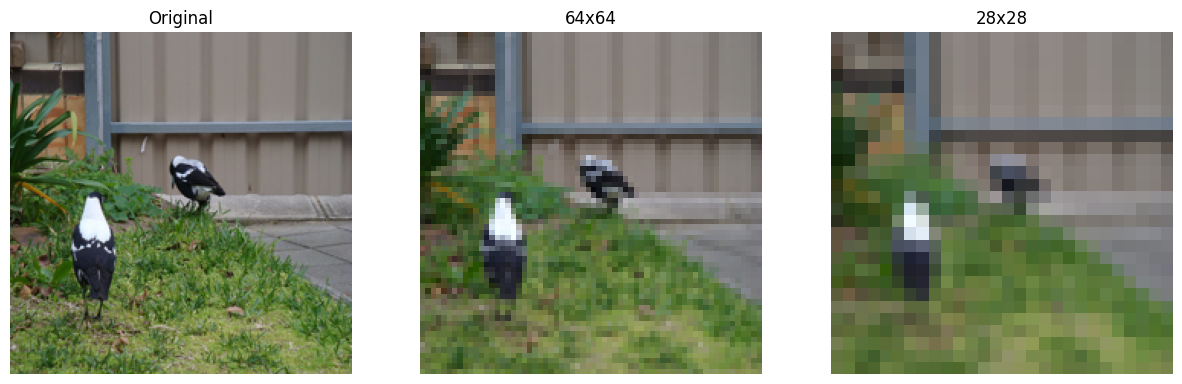

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

img=Image.open("images/SampleImageNet.JPEG").resize((224,224))
imgResized_64=img.resize((64,64))
imgResized_28=img.resize((28,28))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis('off')  
axes[1].imshow(imgResized_64)
axes[1].set_title("64x64")
axes[1].axis('off')  
axes[2].imshow(imgResized_28)
axes[2].set_title("28x28")
axes[2].axis('off')
plt.show()

Como podemos observar, el redimensionamiento no es una buena solución, especialmente si necesitamos identificar detalles de la imagen para una clasificación o detección efectiva.


### Primera capa oculta muy limitada


Una entrada de tamaño $150528$ es aún más problemática cuando la primera capa oculta tiene un gran número de neuronas. Los pesos corresponden a cada conexión entre neuronas de capas sucesivas. Si asumimos que la primera capa oculta tiene $1024$ neuronas, tendríamos $150528 \times 1024 = 154$ millones de pesos, una cantidad enorme solo para la conexión entre las dos primeras capas.

Podríamos considerar tener una primera capa oculta con solo unas pocas decenas de neuronas para limitar el número de pesos. Sin embargo, reducir drásticamente la dimensión conlleva una pérdida considerable de información, lo que impide obtener resultados satisfactorios con este enfoque.


### Las convoluciones


**Intuición**: Una característica particular de las imágenes es la presencia de patrones recurrentes. A partir de esta idea, podemos considerar compartir pesos entre los diferentes píxeles de la imagen.

**Principio básico**: Esto nos lleva al uso de capas de convolución, que emplean filtros de convolución que recorren cada píxel de la imagen. Los valores de estos filtros son entrenables y corresponden a los pesos de la red neuronal.

A continuación, se muestra una ilustración del principio de convolución:

![Convolución](./images/conv.png)


**¿Por qué funciona?**:
- El uso de capas de convolución permite no aumentar el número de pesos en función del tamaño de la imagen, lo que facilita el procesamiento de imágenes de alta resolución.
- La capa de convolución proporciona invariancia a la traslación, algo muy útil para imágenes (una imagen de un perro desplazada 4 píxeles sigue siendo una imagen de un perro).
- Aunque el procesamiento de la información es local en una capa de convolución, la sucesión de capas de convolución permite un tratamiento global de la imagen (ver la sección sobre el campo receptivo en el siguiente notebook).

**Información adicional**:
- En la figura de explicación, la imagen de entrada es de tamaño $4 \times 4$. En la práctica, una imagen en color contiene $3$ canales. Para procesar una imagen de tamaño $4 \times 4 \times 3$, se utilizarían filtros de tamaño $n \times n \times 3$, donde $n$ es el tamaño del filtro ($3$ en la figura de explicación). Es importante recordar que la profundidad del filtro de convolución depende del número de canales de la entrada de la capa.
- Podemos ver la convolución como un bucle *for* aplicado sobre una capa completamente conectada, donde un pequeño filtro (con pesos compartidos en lugar de pesos únicos por conexión) se desliza sobre la imagen para detectar patrones locales. Esto mejora enormemente la eficiencia y permite el uso compartido de pesos, lo que reduce significativamente los requisitos de memoria.


## Detalles de las capas de convolución


Ahora detallaremos los diferentes parámetros de una capa de convolución basándonos en los parámetros de entrada de la función [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) de PyTorch.

Para mayor claridad, la salida de una capa de convolución se denomina *FeatureMap* (mapa de características).


**in_channels**: Número de canales en la entrada de la capa (permite definir la profundidad de los filtros de convolución utilizados).

**out_channels**: Número de filtros de convolución utilizados en la capa (corresponde también al número de canales del *FeatureMap* de salida).

**kernel_size**: Tamaño de un filtro de convolución. Si este parámetro es $3$, entonces el filtro de convolución es de tamaño $3 \times 3$. Todos los filtros de convolución de una misma capa deben tener el mismo tamaño.

**stride**: El *stride* corresponde al paso de aplicación del filtro de convolución. Por ejemplo, un *stride* de $1$ significa que el filtro se aplica a todos los píxeles, mientras que un *stride* de $2$ significa que se aplica a un píxel de cada dos. Un *stride* grande reduce la dimensión de la imagen (con un *stride* de 2, el *FeatureMap* de salida será 2 veces más pequeño que con un *stride* de 1).

**padding**: Este parámetro añade un borde de tamaño *padding* alrededor de la imagen para permitir que los filtros se apliquen uniformemente a todos los píxeles, incluyendo los de los bordes. Sin *padding*, los píxeles del borde no tendrían vecinos y el filtro no podría aplicarse, lo que reduciría el tamaño de la imagen durante la convolución. El *padding* soluciona esto añadiendo valores (como ceros o valores reflejados) alrededor de la imagen antes de aplicar los filtros (ver *zero-padding* en la figura de explicación).

**padding_mode**: Permite seleccionar el modo de *padding* (por ejemplo, "zeros" para *zero-padding*).

**dilation**: El parámetro *dilation* en una capa de convolución define el espaciado entre los elementos del filtro, permitiendo que este cubra un área más amplia sin aumentar su tamaño, lo que captura más contexto espacial en la imagen. La siguiente figura ilustra la *dilation*:

![Dilatación](./images/dilation.png)

Figura extraída de *Du, Jinglong & Wang, Lulu & Liu, Yulu & Zhou, Zexun & He, Zhongshi & Jia, Yuanyuan. (2020). Brain MRI Super-Resolution Using 3D Dilated Convolutional Encoder–Decoder Network. IEEE Access. PP. 1-1. 10.1109/ACCESS.2020.2968395.*


## Las capas de *pooling*


Otra capa fundamental de las redes neuronales convolucionales es la capa de *pooling*. Esta es una capa que no contiene parámetros entrenables y se limita a redimensionar el *feature map* utilizando una técnica de agrupamiento de píxeles adyacentes. En el siguiente notebook, veremos cómo se utiliza esta capa en una red neuronal convolucional. Las capas de *pooling* también tienen el efecto de reducir la sensibilidad a desplazamientos y distorsiones de patrones, lo que favorece una mayor generalización.


Existen 2 tipos principales de *pooling*:
**MaxPooling**: El *MaxPooling* es un método que consiste en tomar el valor máximo de un grupo de píxeles adyacentes y definirlo como el nuevo valor de la imagen reducida.
**AveragePooling**: El *AveragePooling* toma el valor promedio del grupo de píxeles adyacentes y lo define como el nuevo valor de la imagen reducida.

La siguiente figura muestra las diferencias entre *MaxPooling* y *AveragePooling*:

![Pooling](./images/pooling.png)
